## TOC:
* [Imports](#1st)
* [Config](#2nd)
* [Data Import](#3rd)
* [Data exploration](#4th)
* [Data visualization](#5th)
* [Encoding](#6th)
* [Partial Data Preprocessing](#7th)
* [Data Upload](#8th)


## Imports <a class="anchor" id="1st"></a>

In [130]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

import sklearn
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.metrics import accuracy_score,f1_score
from sklearn.svm import SVC
from bayes_opt import BayesianOptimization
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.utils import resample

## Config <a class="anchor" id="2nd"></a>

In [131]:
DROPPED_FAULTY_ENTRIES = False

REDUCED_EDUCATION = False

REDUCED_EMPLOYER = False

REDUCED_LOCATION = False

DROP_UNEMPLOYED = False

SPLIT_RACE = False

OVERSAMPLING = True

## Data Import <a class="anchor" id="3rd"></a>

In [132]:
# Data Read
df_train = pd.read_csv('../../data/raw/teco-psda-exercisesheet1-employment-2024/employment_train.csv',decimal=",")
df_test = pd.read_csv('../../data/raw/teco-psda-exercisesheet1-employment-2024/employment_test.csv',decimal=",")

# Compare Columns to Desc
print(df_test.columns)
print(df_train.columns)

Index(['Unnamed: 0', 'age', 'race', 'earnwke', 'married', 'union', 'ne_states',
       'so_states', 'ce_states', 'we_states', 'government', 'private', 'self',
       'educ_lths', 'educ_hs', 'educ_somecol', 'educ_aa', 'educ_bac',
       'educ_adv', 'female'],
      dtype='object')
Index(['Id', 'age', 'race', 'earnwke', 'employed', 'unemployed', 'married',
       'union', 'ne_states', 'so_states', 'ce_states', 'we_states',
       'government', 'private', 'self', 'educ_lths', 'educ_hs', 'educ_somecol',
       'educ_aa', 'educ_bac', 'educ_adv', 'female'],
      dtype='object')


In [133]:
print(df_train.describe())  

df_train["married"] = df_train["married"].astype("category")
df_train["union"] = df_train["union"].astype("category")
df_train["female"] = df_train["female"].astype("category")

                Id          age         race      earnwke     employed  \
count  5212.000000  5212.000000  5212.000000  4607.000000  5212.000000   
mean   2701.044321    42.123177     1.226401   850.593636     0.889870   
std    1566.134437    11.358779     0.563532   587.112446     0.313082   
min       0.000000    18.000000     1.000000     0.000000     0.000000   
25%    1340.750000    33.000000     1.000000   440.000000     1.000000   
50%    2694.500000    43.000000     1.000000   707.690000     1.000000   
75%    4059.250000    51.000000     1.000000  1100.000000     1.000000   
max    5411.000000    63.000000     3.000000  2884.610000     1.000000   

        unemployed      married        union    ne_states    so_states  ...  \
count  5212.000000  5212.000000  5212.000000  5212.000000  5212.000000  ...   
mean      0.040292     0.647928     0.126055     0.209325     0.293170  ...   
std       0.196661     0.477662     0.331943     0.406866     0.455259  ...   
min       0.00000

## Data exploration <a class="anchor" id="4th"></a>

In [134]:
# First Look at the data

train = df_train.values
train_ids = train[:, 0]
train_employed = train[:, 4]
train_unemployed = train[:, 5]
train_data = train[:,np.array([not i == 4 and  not i == 5  for i in range(1,23)])]
test = df_test.values 

print("Amount of entries and features of training data:", train.shape)
print("Amount of entries:", train_ids.shape)
print("Entry count for employed classification:",train_employed.shape)
print("Amount of entries and features of testing data:", train_data.shape)
print("Amount of entries and features for the final testing data:", test.shape)

print("Amount of missing values: ", df_train.isnull().sum())
## only values which are "zero" are for those who have no weekly income which seems logical in regard to employment

print(df_train.describe())

Amount of entries and features of training data: (5212, 22)
Amount of entries: (5212,)
Entry count for employed classification: (5212,)
Amount of entries and features of testing data: (5212, 20)
Amount of entries and features for the final testing data: (200, 20)
Amount of missing values:  Id                0
age               0
race              0
earnwke         605
employed          0
unemployed        0
married           0
union             0
ne_states         0
so_states         0
ce_states         0
we_states         0
government        0
private           0
self              0
educ_lths         0
educ_hs           0
educ_somecol      0
educ_aa           0
educ_bac          0
educ_adv          0
female            0
dtype: int64
                Id          age         race      earnwke     employed  \
count  5212.000000  5212.000000  5212.000000  4607.000000  5212.000000   
mean   2701.044321    42.123177     1.226401   850.593636     0.889870   
std    1566.134437    11.358779   

In [135]:
print("Amount of employed individuals in data set:", train[:,4].sum())
print("By percentage:", ((train[:,4].sum())/(len(train[:,4]))))
print("Amount of unemployed individuals in data set: ", train[:,5].sum())
print("By percentage:", ((train[:,5].sum())/(len(train[:,5]))))


ctr_50 = 0
ctr_51 = 0
ctr_40 = 0
ctr_41 = 0

#Test for completeness of data
for i in range(0, len(train[:,5])):
    if train[i, 5] == 1: ctr_51 += 1
    if train[i, 5] == 0: ctr_50 += 1
    if train[i, 4] == 1: ctr_41 += 1
    if train[i, 4] == 0: ctr_40 += 1   
print("Für Unemployment 0: ",ctr_50,"1: ",ctr_51,"Summe: ",ctr_50 + ctr_51)
print("Für Employment 0: ",ctr_40,"1: ",ctr_41,"Summe: ",ctr_40 + ctr_41)

Amount of employed individuals in data set: 4638.0
By percentage: 0.8898695318495778
Amount of unemployed individuals in data set:  210.0
By percentage: 0.04029163468917882
Für Unemployment 0:  5002 1:  210 Summe:  5212
Für Employment 0:  574 1:  4638 Summe:  5212


In [136]:
ctr_00 = 0
ctr_11 = 0
age_array = []

#Comparing of employed & unemployed for nonsensical data
for i in range(0, len(train[:,4])):
    if train[i,4] == train[i,5]:
        if train[i,4] == 0: ctr_00 += 1
        if train[i,4] == 1: ctr_11 += 1
        age_array += [train[i,1]]
        #print(train[i,0:6])
print("Amount of anomalistic entries in regard to age: ",len(age_array))
print("Neither aka 00:", ctr_00)
print("Both aka 11:", ctr_11)

Amount of anomalistic entries in regard to age:  364
Neither aka 00: 364
Both aka 11: 0


In [137]:

#Check for edge cases in regard to the working age and the age of maturity 
child_ctr = 0
for i in range(0, len(train[:,4])):
    if train[i,1] < 18: 
        child_ctr += 1

print("Amount of children in the data:", child_ctr)

Amount of children in the data: 0


In [138]:

ctr_1000 = 0
ctr_0111 = 0
job_array = []

for i in range(0, len(train[:,4])):
    # Check if employed w/o prev anomalies
    if train[i,4] == 1 and train[i,4] != train[i,5]:
         if train[i,12] == 0 and train[i,13] == 0 and train[i,14] == 0:
            ctr_1000 += 1
            job_array += [train[i,1]]
            print(train[i,0],train[i,4],train[i,12:15])
    if train[i,4] == 0 and train[i,4] != train[i,5]:
        if train[i,12] == 0 or train[i,13] == 0 or train[i,14] == 0:
            ctr_0111 += 1
            job_array += [train[i,1]]
            print(train[i,0],train[i,4],train[i,12:15])
    
                
print("Amount of anomalistic entries in regard to employer: ",len(job_array))
print("Has a job but neither private nor governmental:", ctr_1000)
print("No job but still employed 011:", ctr_0111)

22.0 0.0 [0. 1. 0.]
53.0 0.0 [0. 1. 0.]
66.0 0.0 [0. 1. 0.]
85.0 0.0 [0. 1. 0.]
99.0 0.0 [0. 1. 0.]
104.0 0.0 [0. 1. 0.]
116.0 0.0 [0. 1. 0.]
130.0 0.0 [0. 1. 0.]
141.0 0.0 [0. 1. 0.]
169.0 0.0 [0. 1. 0.]
185.0 0.0 [0. 1. 0.]
201.0 0.0 [0. 1. 0.]
208.0 0.0 [0. 1. 0.]
228.0 0.0 [0. 1. 0.]
229.0 0.0 [0. 1. 0.]
248.0 0.0 [0. 1. 0.]
269.0 0.0 [0. 1. 0.]
293.0 0.0 [0. 1. 0.]
340.0 0.0 [0. 1. 0.]
350.0 0.0 [0. 1. 0.]
379.0 0.0 [0. 1. 0.]
427.0 0.0 [0. 1. 0.]
448.0 0.0 [0. 1. 0.]
462.0 0.0 [0. 1. 0.]
479.0 0.0 [0. 1. 0.]
497.0 0.0 [0. 0. 1.]
515.0 0.0 [1. 0. 0.]
577.0 0.0 [0. 1. 0.]
600.0 0.0 [0. 1. 0.]
639.0 0.0 [0. 1. 0.]
656.0 0.0 [0. 1. 0.]
685.0 0.0 [0. 1. 0.]
763.0 0.0 [1. 0. 0.]
797.0 0.0 [0. 1. 0.]
812.0 0.0 [0. 1. 0.]
819.0 0.0 [0. 1. 0.]
822.0 0.0 [0. 1. 0.]
826.0 0.0 [0. 1. 0.]
848.0 0.0 [0. 1. 0.]
904.0 0.0 [0. 1. 0.]
908.0 0.0 [0. 1. 0.]
928.0 0.0 [0. 1. 0.]
934.0 0.0 [0. 1. 0.]
998.0 0.0 [0. 1. 0.]
1045.0 0.0 [0. 1. 0.]
1067.0 0.0 [0. 1. 0.]
1068.0 0.0 [0. 1. 0.]
1087.0 0.0 [0. 

## Data visualization <a class="anchor" id="5th"></a>

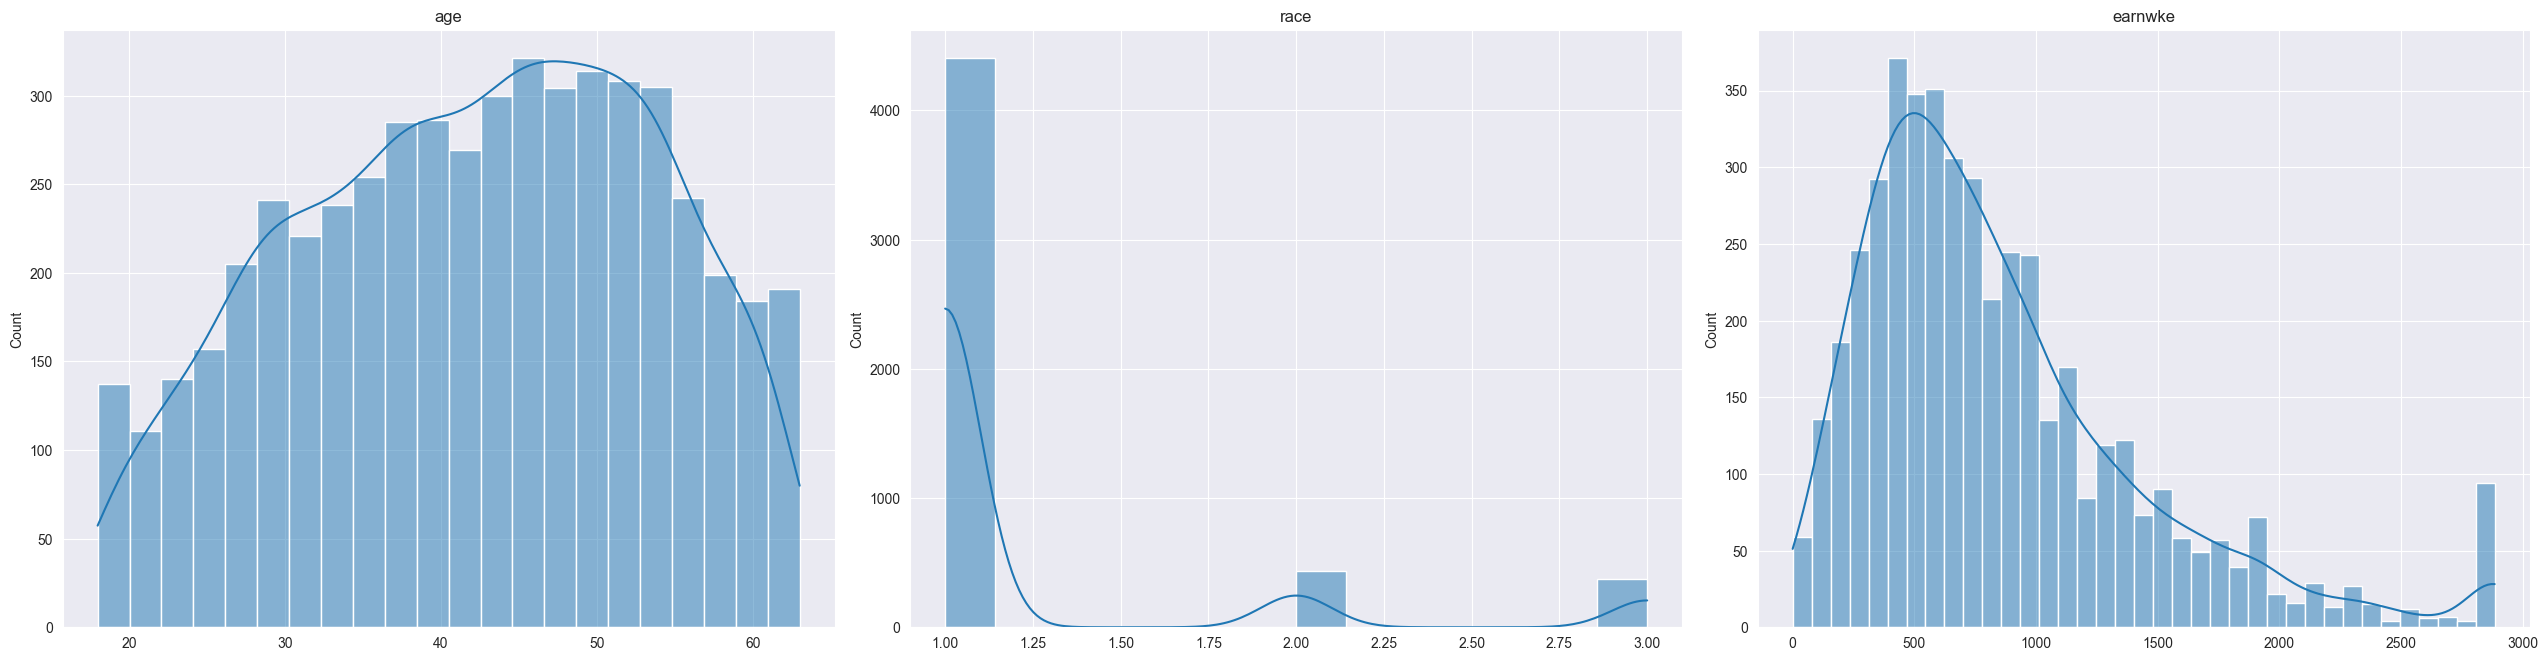

In [139]:
# Data Visualization
# Plot histograms for continuous variables

continuous_cols = ['age', 'race', 'earnwke']

sqr_n= round(np.sqrt(len(continuous_cols)))+1

plt.figure(figsize=(25.6, 19.2))
for i, col in enumerate(continuous_cols, 1):
    plt.subplot(sqr_n, sqr_n, i)
    sns.histplot(train[:,i],kde = True)
    plt.title(col)
plt.tight_layout()
plt.show()

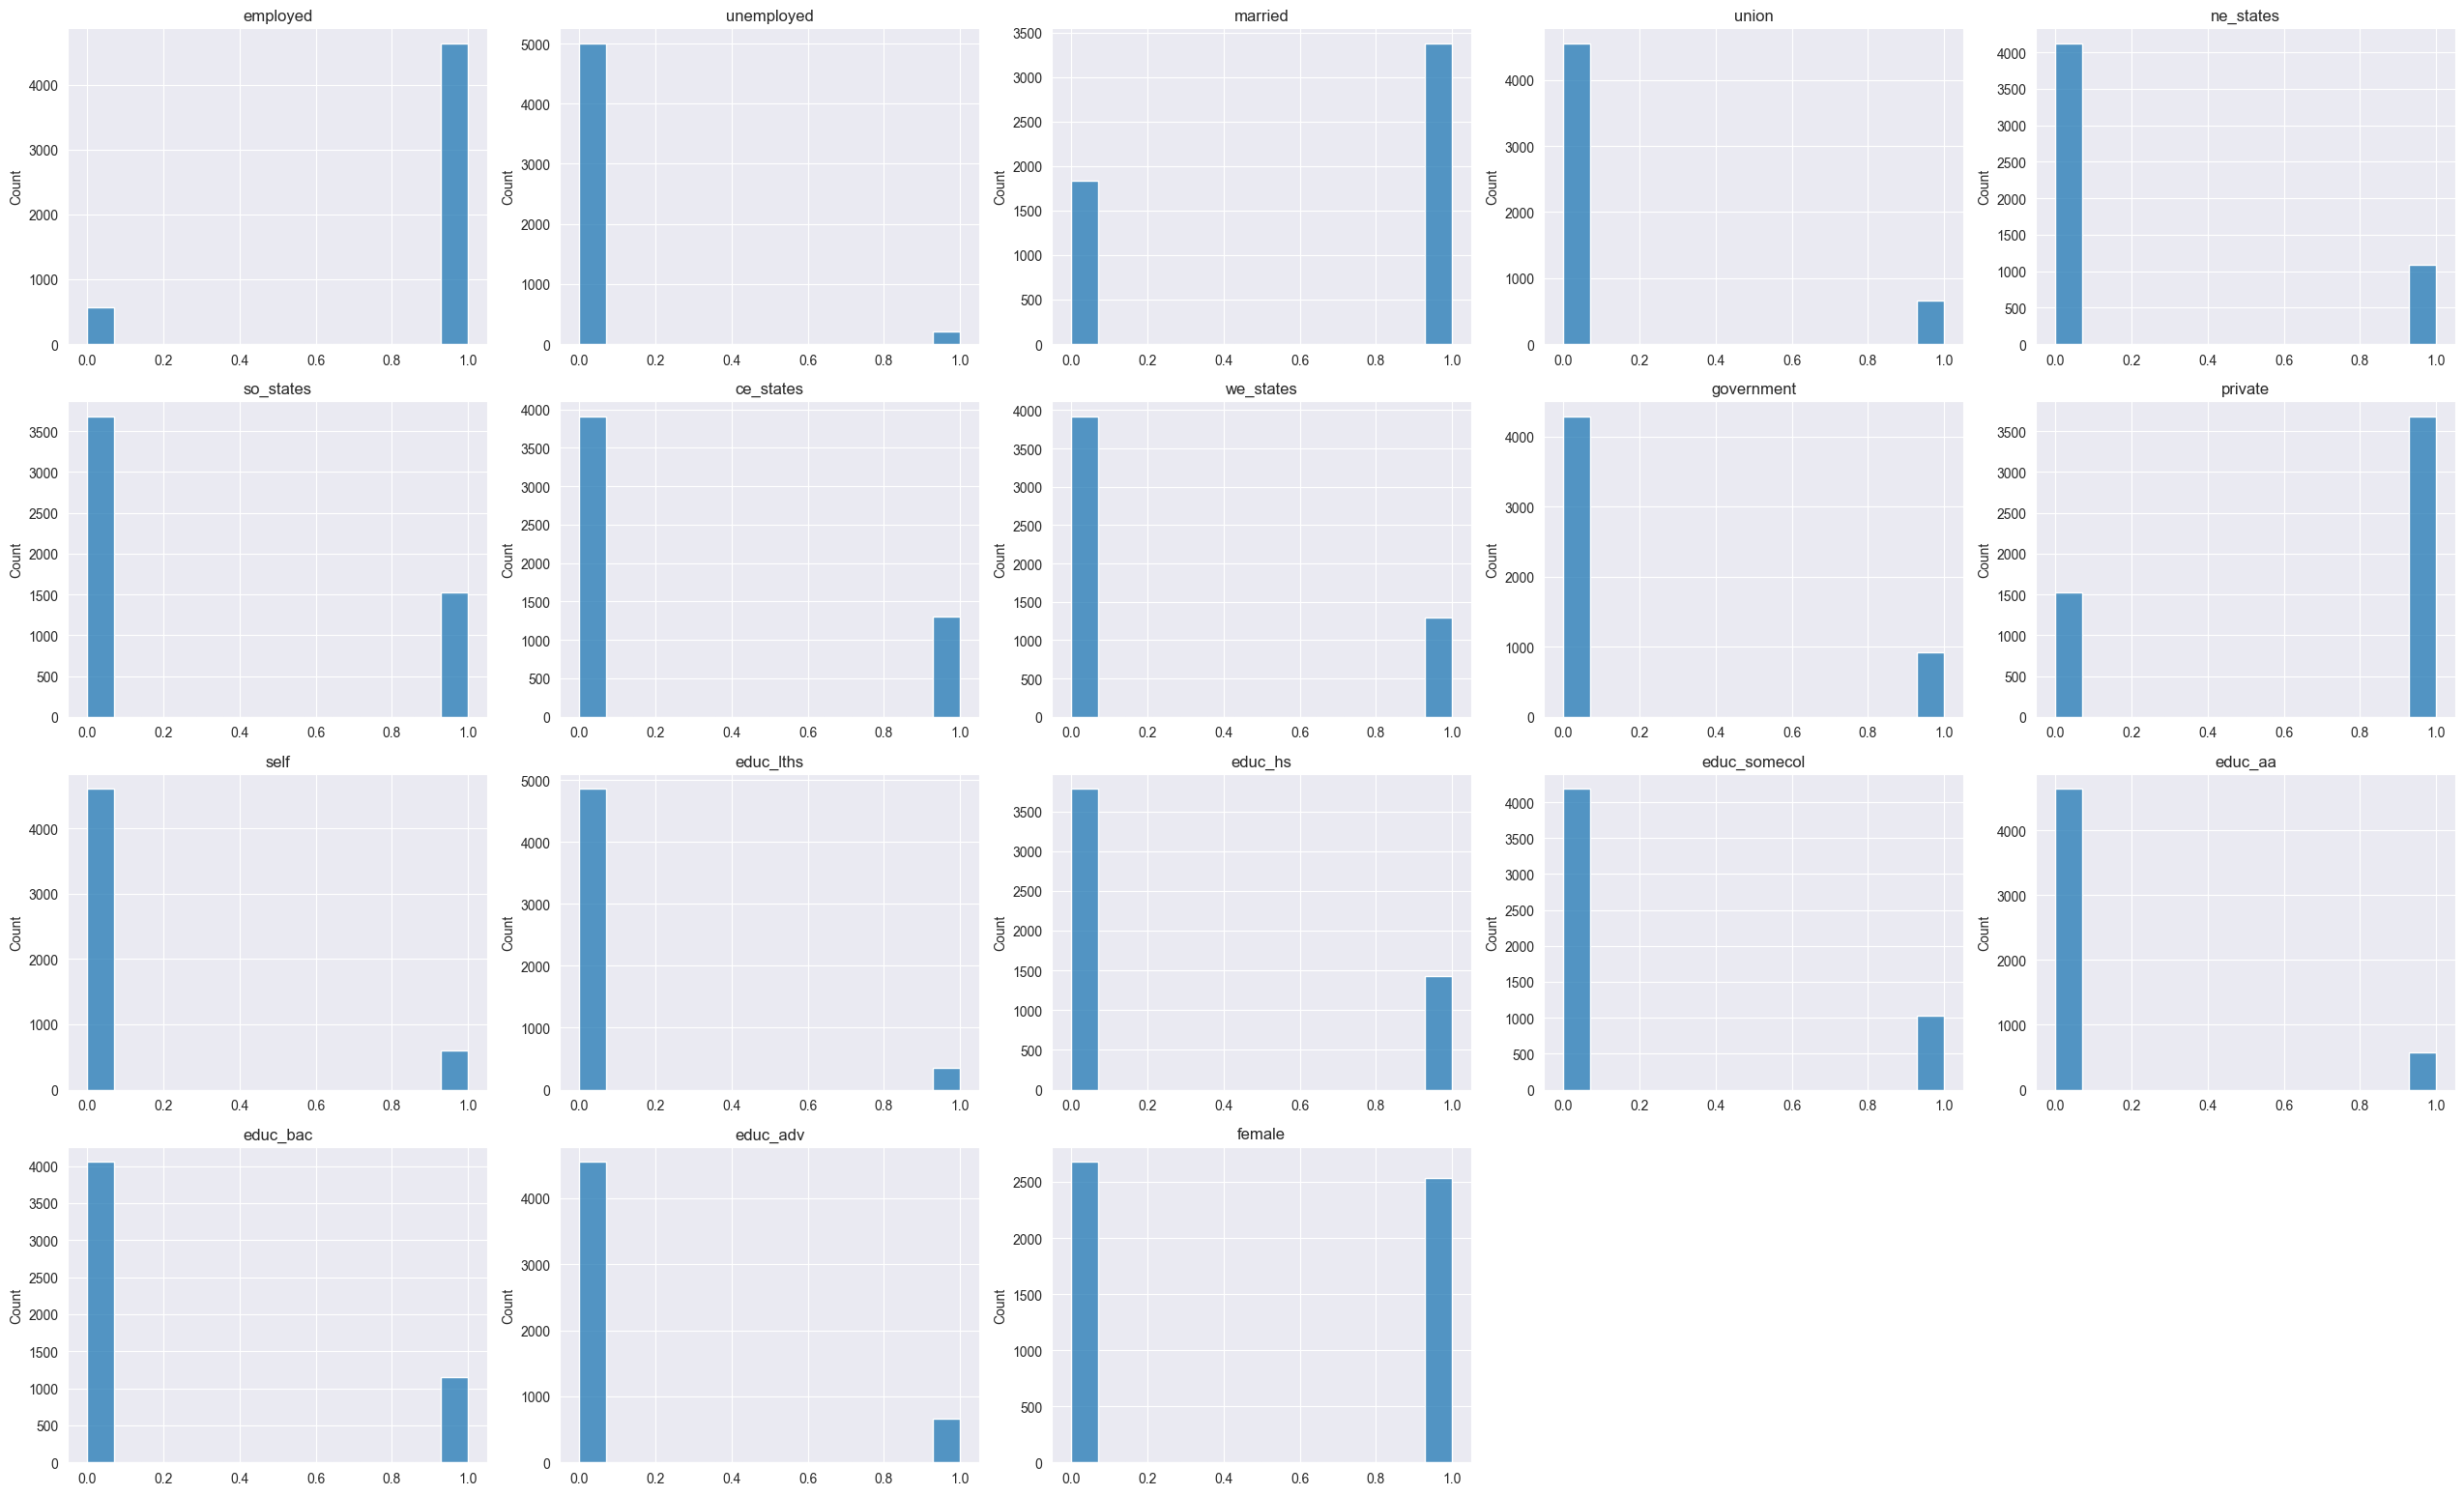

In [140]:
# Plot count plots for categorical variables
categorical_cols = ['employed', 'unemployed', 'married', 'union', 'ne_states', 'so_states', 'ce_states', 'we_states', 'government', 'private', 'self', 'educ_lths', 'educ_hs', 'educ_somecol', 'educ_aa', 'educ_bac', 'educ_adv', 'female']

sqr_n= round(np.sqrt(len(categorical_cols)))+1

plt.figure(figsize=(25.6, 19.2))
for i, col in enumerate(categorical_cols, 1):
    plt.subplot(sqr_n,sqr_n,i)
    sns.histplot(train[:,i+3])
    plt.title(col)  
plt.tight_layout()
plt.show()

c:\users\c-beh\appdata\local\programs\python\python39\lib\site-packages\seaborn\axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


<Figure size 1.02004e+06x1920 with 0 Axes>

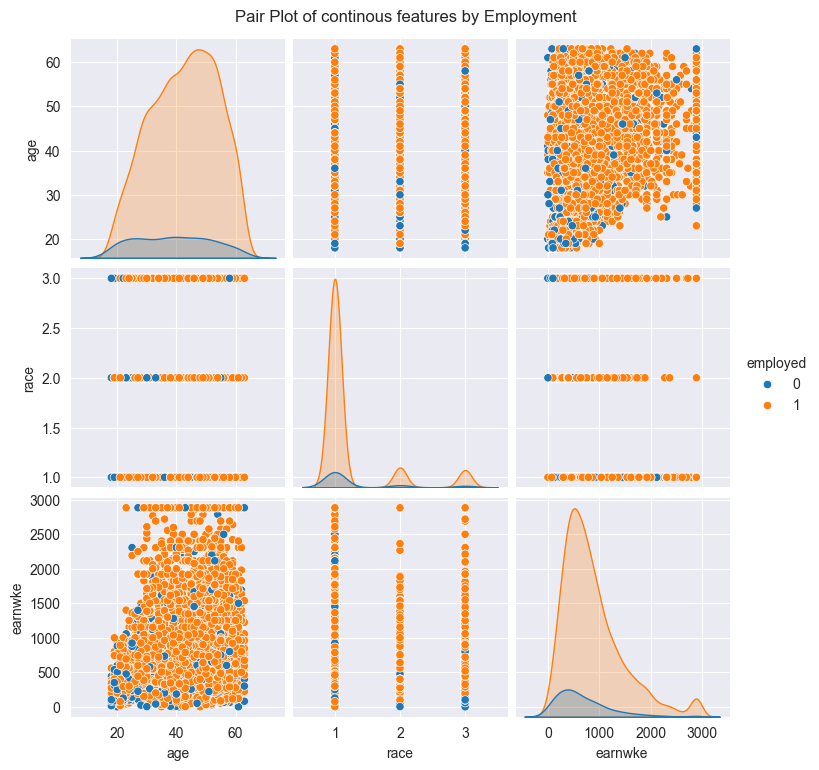

In [141]:
plt.figure(figsize=(10200.4, 19.2))
sns.pairplot(df_train.loc[:,continuous_cols + ["employed"]], hue='employed')
plt.suptitle('Pair Plot of continous features by Employment', y=1.02)
#plt.tight_layout()
plt.show()

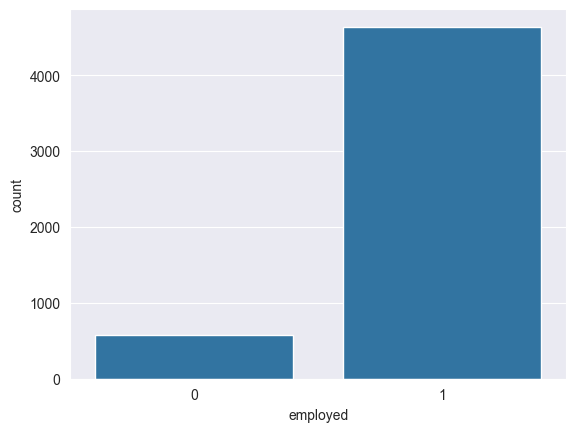

In [142]:
sns.countplot(data=df_train, x="employed")
plt.show()

Notes: 

<s>Current understanding is that employed & unemployed are NOT exclusive</s>
After contemplation certain sets do not make sense, therefore I will remove such nonsensical data entries

Furthermore the data set is very unbalanced towards employment in regard to the target and certain other features are also quite unbalanced (i.e. union, private)
 

## Encoding <a class="anchor" id="6th"></a>

In [143]:
# Substituting the missing earning values with "0"
df_train.fillna(0, inplace=True)
df_test.fillna(0, inplace=True)
train = df_train.values
test = df_test.values
df_train = pd.DataFrame(train, columns=df_train.columns)
print(df_train.columns)

continuous_cols = ['age', 'race', 'earnwke']
categorical_cols = ['employed', 'unemployed', 'married', 'union', 'ne_states', 'so_states', 'ce_states', 'we_states', 'government', 'private', 'self', 'educ_lths', 'educ_hs',  'educ_somecol', 'educ_aa', 'educ_bac', 'educ_adv', 'female']

Index(['Id', 'age', 'race', 'earnwke', 'employed', 'unemployed', 'married',
       'union', 'ne_states', 'so_states', 'ce_states', 'we_states',
       'government', 'private', 'self', 'educ_lths', 'educ_hs', 'educ_somecol',
       'educ_aa', 'educ_bac', 'educ_adv', 'female'],
      dtype='object')


In [145]:
continuous_cols = ['age', 'race', 'earnwke']
categorical_cols = ['employed', 'unemployed', 'married', 'union', 'ne_states', 'so_states', 'ce_states', 'we_states', 'government', 'private', 'self', 'educ_lths', 'educ_hs',  'educ_somecol', 'educ_aa', 'educ_bac', 'educ_adv', 'female']

# No noticeable difference therefore not currently in use
# Introduction of correlation between the education features and reduction of the overall amount of features
if REDUCED_EDUCATION:
    categorical_cols.remove("educ_lths")
    categorical_cols.remove("educ_hs")
    categorical_cols.remove("educ_somecol")
    categorical_cols.remove("educ_aa")
    categorical_cols.remove("educ_bac")
    categorical_cols.remove("educ_adv")
    
    continuous_cols.append("educ")
    
    educ_val = np.zeros(len(df_train))
    for i in range(0, len(df_train)):
        if train[i,15]  == 1:   
            educ_val[i] = 0
        if train[i,16]  == 1:   
            educ_val[i] = 1
        if train[i,17]  == 1:   
            educ_val[i] = 2
        if train[i,18]  == 1:   
            educ_val[i] = 3
        if train[i,19]  == 1:   
            educ_val[i] = 4
        if train[i,20]  == 1:   
            educ_val[i] = 5
        
    df_train.insert(loc=15,column="educ",value=educ_val)
    # Removing the old data sets
    df_train.drop(columns=['educ_lths','educ_hs','educ_somecol','educ_aa', 'educ_bac', 'educ_adv'], inplace=True)  
    print(df_train.columns)
   

In [146]:
# Not in use since it was less than helpful
if REDUCED_EMPLOYER:
    categorical_cols.remove("government")
    categorical_cols.remove("private")
    categorical_cols.remove("self")
    
    continuous_cols.append("employer")

In [147]:
# Not in use since there was no visible benefit
# Reduction in the amount of features by reducing the 4 regions into the cardinal directions to help identify potential 
if REDUCED_LOCATION:
    categorical_cols.remove("ne_states")
    categorical_cols.remove("so_states")
    categorical_cols.remove("ce_states")
    categorical_cols.remove("we_states")
    
    continuous_cols.append("north/south")
    continuous_cols.append("east/west")
  

In [148]:
# Since we only need one target value & unemployed is simply the inverse of employed we can drop unemployed
if DROPPED_FAULTY_ENTRIES:
    categorical_cols.remove("unemployed")
    

In [149]:
# To reduce the introduce correlation between different races/ethnicities we try to split them into different features
if SPLIT_RACE:
    continuous_cols.remove("race")
    
    categorical_cols.append("Race1")
    categorical_cols.append("Race2")
    categorical_cols.append("Race3")

In [150]:
print(categorical_cols)
print(continuous_cols)

['employed', 'unemployed', 'married', 'union', 'ne_states', 'so_states', 'ce_states', 'we_states', 'government', 'private', 'self', 'educ_lths', 'educ_hs', 'educ_somecol', 'educ_aa', 'educ_bac', 'educ_adv', 'female']
['age', 'race', 'earnwke']


## Partial Data Preprocessing <a class="anchor" id="7th"></a>

In [151]:
# Since there are much more data points for employed people we oversample the unemployed people to get balance between both 
if OVERSAMPLING:
    df_employed = df_train[(df_train["employed"]==1)]
    df_unemployed = df_train[(df_train["employed"]==0)]
    
    print(len(df_employed))
    print(len(df_unemployed))
    
    df_unemployed_extended = resample(df_unemployed, replace=True, n_samples=len(df_employed), random_state=9)    
    print(len(df_unemployed_extended)) #
    
    df_train = pd.concat([df_employed,df_unemployed_extended])    
    print(len(df_train))

4638
574
4638
9276


In [152]:
# List of IDs of faulty entries
if DROPPED_FAULTY_ENTRIES:
    train = df_train.values
    
    fEntriesIDs = []
    for i in range(0,len(train[:,4])):
        if train[i,4] == train[i,5]:
            fEntriesIDs += [i]
    
    df_train = pd.DataFrame(train)
    #print(fEntriesIDs)

    # Trying out df.drop - columns
    #print(df_train.columns)
    #df_dup = df_train.copy(deep=True)
    #df_dup.drop(columns=['employed','unemployed'], inplace=True)
    #print(df_dup.columns)

<class 'numpy.ndarray'>


## Data Upload <a class="anchor" id="8th"></a>

In [153]:
#Processed Data to storage, so it can be used for the predictions
train = df_train.values

In [154]:
new_columns_train = df_train.columns
proc_data_train = train

new_columns_test = df_test.columns
proc_data_test = test

df_proc_train = pd.DataFrame(proc_data_train, columns = new_columns_train)
df_proc_test = pd.DataFrame(proc_data_test, columns = new_columns_test)

df_proc_train.to_csv('../../data/processed/employment_train_processed.csv',index=False)
df_proc_test.to_csv('../../data/processed/employment_test_processed.csv',index=False)